# Apartment search 


This notebook contains an example of how to use openrouteservice API's to create isochrones. 

In [159]:
import folium
import json
import os
import matplotlib as mpl
from openrouteservice import client
import pandas as pd
from matplotlib import pyplot as plt
import datetime as dt
import requests

Paste your personal API key below.

In [61]:
api_key = '5b3ce3597851110001cf62483ae5cf98ae4743649600ff877943b339' #Provide your personal API key
myClient = client.Client(key=api_key) 

Let's assume you are seraching for a new appartment in San Francisco. There are three potential appartments. We will create ischonres around each one.

## Create a list of potential apartments
First, we store the locations of the three potential appartments in a dictionary.

In [170]:
# Set up the apartment dictionary with real coordinates
apartments = {'first_apartment': {'location': [9.981727, 53.552018]},
            'second_apartment': {'location': [9.921727, 53.552018]},
            'third_apartment': {'location': [9.981727, 53.572018]}
           }

In [171]:
apartments['first_apartment']['location']

[9.981727, 53.552018]

## Create isochrones around appartments

Then, we will request the isochrones around each apparment and visualize them in the map. You may change the settings of the isochrones. For details about the parameters see the [ORS documentation](https://openrouteservice.org/dev/#/api-docs/isochrones).

In [172]:
# Settings for isochrones
# ORS routing profile
profile = 'foot-walking'
# Type of isochones: time or distance
range_type = 'time'
# Intervals of isochrones
intervals = [500] # in seconds (if range_type=time) or meters (if range_type=distance)
# If this variable is True, the isochorones are exported into a geojson file 
export_isochrones_to_file = True
# Path to the folder where the files containgin the isochrones should be stored
path_out = '/Users/chludwig/Data/temp/'


# Store parameters of the isochrones request in a python dictionary 
params_iso = {'profile': profile,
              'intervals': intervals, # 900/60 = 15 mins
              'segments': intervals[0],
              'range_type': range_type,
              'attributes': ['area'] # Get area of each isochrone
             }

# Defines the style of the isochrones shown in the map
style_function = lambda x: {'weight': 1}

# Create map object
mapSF = folium.Map(tiles='Stamen Toner', location=([53.552018, 9.981727]), zoom_start=12)

# Iterate over all appartments and request isochrones for each one and add them to the map
for name, apt in apartments.items():
    # Add apartment coords to request parameters
    params_iso['locations'] = apt['location'] 
    # Perform isochrone request
    apt['iso'] = myClient.isochrones(**params_iso) 
    # Add resulting isochrones to the map
    folium.features.GeoJson(apt['iso'], style_function=style_function, name='Isochrones of ' + name).add_to(mapSF) 
    # Add icon at the location of the appartment
    folium.map.Marker(list(reversed(apt['location'])), # reverse coords due to weird folium lat/lon syntax
                      icon=folium.Icon(color='lightgray',
                                        icon_color='#cc0000',
                                        icon='home',
                                        prefix='fa',
                                       ),
                      popup=name,
                 ).add_to(mapSF)
    # Export to file 
    if export_isochrones_to_file:
        with open(os.path.join(path_out, 'isochrones_' + name +'.geojson'), "w") as fp: 
            json.dump(apt['iso'], fp)

# Add layer control so you can toggle layers on and off
mapSF.add_child(folium.LayerControl())
# display map
mapSF

## Number of restaurants nearby apartments

In [176]:
#Define temporal filter, make sure to use ISO-8601 conform timestrings
start_date = '2013-01-01'
end_date = '2018-04-01'
time_interval = 'P1M' 

apt = apartments['third_apartment']
    
#Specified data to be sent to the ohsome API
data = {'bpolys': json.dumps(apt['iso']),
        'keys': 'amenity',
        'values': 'restaurant',
        'time': f'{start_date}/{end_date}/{time_interval}',
        #'time': f'{end_date}',
        'showMetadata': 'true'}

#Send  post request to ohsome api and save response
count_ohsome_endpoint = 'https://api.ohsome.org/v0.9-ignite-germany/elements/count/'
count = requests.post(count_ohsome_endpoint, data=data).json()

In [177]:
#Visualize the count of restaurants within the isochrone
df_count = pd.DataFrame(count['result'])
df_count.timestamp = pd.to_datetime(df_count.timestamp, format='%Y-%m-%dT%H:%M:%SZ')
df_count.set_index("timestamp")
df_count.head()

,timestamp,value
0,2013-01-01,35.0
1,2013-02-01,35.0
2,2013-03-01,35.0
3,2013-04-01,35.0
4,2013-05-01,35.0


Text(0.5, 1.0, 'Number of restaurants')

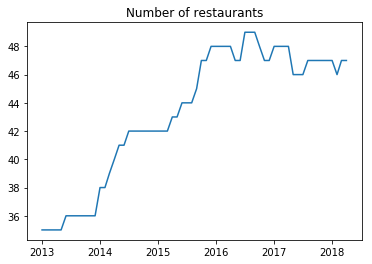

In [178]:
%matplotlib inline 
plt.plot(df_count['timestamp'], df_count['value'])
plt.title("Number of restaurants")